In [1]:
# BLOCK 1: Imports
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import ( 
                            accuracy_score, confusion_matrix, classification_report, roc_curve, auc, f1_score, log_loss, 
                            precision_score, recall_score, matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score, 
                            roc_auc_score, precision_recall_curve
    )
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.utils.class_weight import compute_class_weight

from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import ADASYN, SVMSMOTE, SMOTE

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import swish
from tensorflow.keras.losses import BinaryFocalCrossentropy

import lightgbm as lgb
from catboost import CatBoostClassifier

import shap

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
tf.get_logger().setLevel('ERROR')


c:\Users\jakub\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# BLOCK 2: Load Datasets

#file_paths = [
#    r'C:\Users\jakub\Visual Studio Code sem2\Magister\original\heart1.csv',
#    r'C:\Users\jakub\Visual Studio Code sem2\Magister\original\Heart_disease_cleveland_new.csv',
#    r'C:\Users\jakub\Visual Studio Code sem2\Magister\original\framingham_balanced1.csv',
#    r'C:\Users\jakub\Visual Studio Code sem2\Magister\original\heart.csv',
#    r'C:\Users\jakub\Visual Studio Code sem2\Magister\original\cardio_train.csv',
#]

#DATASET_TYPES = {
#    'framingham_balanced1.csv': 'framingham',
#    'cardio_train.csv': 'cardio',
#}

#DATASET_MAPPING = {
#    'heart1.csv': 'heart',
#    'Heart_disease_cleveland_new.csv': 'cleveland',
#    'framingham_balanced1.csv': 'framingham',
#    'heart.csv': 'heart',
#    'cardio_train.csv': 'cardio'
#} 

file_paths = [
    r'C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\heart1_augmented.csv',
    r'C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\Heart_disease_cleveland_new_augmented.csv',
    r'C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\framingham_balanced1_augmented.csv',
    r'C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\heart_augmented.csv',
    r'C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\cardio_train_augmented.csv',
]

DATASET_TYPES = {
    'framingham_balanced1_augmented.csv': 'framingham',
    'cardio_train_augmented.csv': 'cardio',
}

DATASET_MAPPING = {
    'heart1_augmented.csv': 'heart',
    'Heart_disease_cleveland_new_augmented.csv': 'cleveland',
    'framingham_balanced1_augmented.csv': 'framingham',
    'heart_augmented.csv': 'heart',
    'cardio_train_augmented.csv': 'cardio'
} 

target_columns = ['target'] * 5 


In [3]:
# BLOCK 3: Preprocess Data
def preprocess_framingham(df):
    np.random.seed(42)
    random.seed(42)
    
    df = df.rename(columns={
        'male': 'sex',
        'currentSmoker': 'smoke',
        'totChol': 'chol',
        'sysBP': 'trestbps',
        'heartRate': 'thalach',
        'TenYearCHD': 'target',
        'glucose': 'fbs'
    })
    
    df['fbs'] = df['fbs'].apply(lambda x: 1.0 if x > 120 else 0.0 if pd.notnull(x) else np.nan)
    
    return df[['age', 'sex', 'education', 'trestbps', 'chol', 'fbs', 'diaBP', 
              'thalach', 'BPMeds', 'smoke', 'cigsPerDay', 'prevalentStroke', 
              'prevalentHyp', 'diabetes', 'BMI', 'target']]

def preprocess_cardio(df):
    np.random.seed(42)
    random.seed(42)
    
    df = df.drop(columns=['id'], errors='ignore')
    
    df = df.rename(columns={
        'gender': 'sex',
        'ap_hi': 'trestbps',
        'ap_lo': 'diaBP',
        'cholesterol': 'chol',
        'gluc': 'fbs',
        'cardio': 'target'
    })
    
    df['age'] = (df['age'].astype(float) / 365).round().astype(int)
    
    df['sex'] = df['sex'].astype(int) - 1

    def map_chol(x):
        try:
            x = int(x)
            if x == 1: return np.random.randint(180, 200)
            if x == 2: return np.random.randint(200, 240)
            if x == 3: return np.random.randint(240, 301)
            return x
        except:
            return np.nan

    df['chol'] = df['chol'].apply(map_chol).astype(float)


    def map_fbs(x):
        try:
            x = int(x)
            if x == 1: return np.random.randint(70, 120)
            if x == 2: return np.random.randint(121, 145)
            if x == 3: return np.random.randint(146, 201)
            return x
        except:
            return np.nan
    
    df['fbs'] = df['fbs'].apply(map_fbs).astype(float)
    df['fbs'] = (df['fbs'] > 120).astype(int)
    

    return df[['age', 'sex', 'trestbps', 'chol', 'fbs', 'diaBP', 'smoke', 
              'alco', 'active', 'height', 'weight', 'target']]

def preprocess_dataset(df, dataset_type):
    if dataset_type == 'framingham':
        return preprocess_framingham(df)
    elif dataset_type == 'cardio':
        return preprocess_cardio(df)
    else:
        df = df.copy()
        if 'target' not in df.columns:
            if 'disease' in df.columns:
                df = df.rename(columns={'disease': 'target'})
            elif 'condition' in df.columns:
                df = df.rename(columns={'condition': 'target'})
        return df

def preprocess_data(df, target_column, dataset_type=None):
    df = preprocess_dataset(df, dataset_type)
    
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataset")
    
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.25, 
        random_state=42, 
        stratify=y
    )
    
    imputer = IterativeImputer(max_iter=15, random_state=42)
    scaler = RobustScaler()
    
    X_train_imp = imputer.fit_transform(X_train)
    X_train_scaled = scaler.fit_transform(X_train_imp)
    
    X_test_imp = imputer.transform(X_test)
    X_test_scaled = scaler.transform(X_test_imp)
    
    smote = SVMSMOTE(
        sampling_strategy='auto', 
        k_neighbors=10,
        m_neighbors=10,
        svm_estimator=SVC(kernel='linear', class_weight='balanced'),
        random_state=42
    )
    X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
    
    return X_train_res, X_test_scaled, y_train_res, y_test

In [4]:
# BLOCK 4: Create Deep Neural Network Model
def create_deep_model(input_dim, output_dim):
    model = Sequential()

    model.add(Input(shape=(input_dim,)))

    model.add(Dense(512, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.2))

    model.add(Dense(256, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.2))

    model.add(Dense(128, activation=swish))
    model.add(BatchNormalization())
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.2))

    activation = 'softmax' if output_dim > 1 else 'sigmoid'
    loss = 'categorical_crossentropy' if output_dim > 1 else 'binary_crossentropy'
    
    model.add(Dense(output_dim, activation=activation))
    
    model.compile(
        loss=BinaryFocalCrossentropy(
            gamma=1.0,
            alpha=0.5  
        ),
        optimizer=Adam(learning_rate=0.0001),
        metrics=['AUC', 'Precision', 'Recall']
    )
    return model

In [5]:
# BLOCK 5: Train Model
def train_model(X_train, y_train, classifier_choice):
    start_time = time.time()
    if classifier_choice == 1:
        model = LogisticRegression()
    elif classifier_choice == 2:
        model = RandomForestClassifier()
    elif classifier_choice == 3:
        model = KNeighborsClassifier()
    elif classifier_choice == 4:
        model = SVC(probability=True)
    elif classifier_choice == 5:
        input_dim = X_train.shape[1]
        output_dim = len(np.unique(y_train))
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weights = dict(enumerate(class_weights))
        if output_dim > 1:
            y_train = to_categorical(y_train)
        model = create_deep_model(input_dim, output_dim)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0.000001)
        model.fit(
            X_train, y_train,
            epochs=250,
            batch_size=32,
            validation_split=0.25,
            callbacks=[early_stopping, reduce_lr],
            verbose=1,
            class_weight=class_weights
        )
        end_time = time.time()
        print(f"[TRAINING TIME] DNN: {end_time - start_time:.2f} seconds")
        return model
    elif classifier_choice == 6:
        model = lgb.LGBMClassifier()
    elif classifier_choice == 7:
        model = CatBoostClassifier(verbose=0)
    else:
        raise ValueError("Invalid classifier choice.")

    model.fit(X_train, y_train)
    end_time = time.time()
    print(f"[TRAINING TIME] Classifier {classifier_choice}: {end_time - start_time:.2f} seconds")
    return model

In [6]:
# BLOCK 6: Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



In [7]:
# BLOCK 7: ROC Curve
def plot_roc_curve(y_test, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


In [14]:
# BLOCK 8: Evaluate Model
def evaluate_model(classifier_choice):
    print(f"Classifier {classifier_choice}:")
    for dataset_index, file_path in enumerate(file_paths):
        print(f"Dataset {dataset_index + 1}: {file_path}")
        df = pd.read_csv(file_path)

        if dataset_index >= len(target_columns):
            print(f"Error: No target column specified for dataset {dataset_index + 1}")
            continue

        dataset_name = os.path.basename(file_path)
        dataset_type = DATASET_MAPPING.get(dataset_name, None)
    
        X_train, X_test, y_train, y_test = preprocess_data(
            df, 
            target_columns[dataset_index], 
            dataset_type=dataset_type
        )
        model = train_model(X_train, y_train, classifier_choice)

        if classifier_choice in [1, 2, 3, 4, 6, 7]:
            start_pred_time = time.time()
            y_pred_prob = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)
            end_pred_time = time.time()
        elif classifier_choice == 5:
            start_pred_time = time.time()
            y_pred_prob = model.predict(X_test)
            if y_pred_prob.ndim > 1 and y_pred_prob.shape[1] > 1:
                y_pred = np.argmax(y_pred_prob, axis=1)
                y_pred_prob = y_pred_prob[:, 1]
            else:
                y_pred = (y_pred_prob > 0.05).astype(int)
            end_pred_time = time.time()
        if len(y_test) != len(y_pred):
            raise ValueError(f"Inconsistent number of samples: y_test={len(y_test)}, y_pred={len(y_pred)}")
        print(f"[INFERENCE TIME] Classifier {classifier_choice} on {dataset_name}: {end_pred_time - start_pred_time:.2f} seconds")

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        logloss = log_loss(y_test, y_pred_prob, labels=np.unique(y_test))
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred, average='weighted')
        mcc = matthews_corrcoef(y_test, y_pred)
        cohen_kappa = cohen_kappa_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"Log-loss: {logloss:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Balanced Accuracy: {balanced_acc:.4f}")
        print(f"G-Mean: {g_mean:.4f}")
        print(f"MCC: {mcc:.4f}")
        print(f"Cohen's Kappa: {cohen_kappa:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")

        plot_roc_curve(y_test, y_pred_prob)
        cm = confusion_matrix(y_test, y_pred)
        plot_confusion_matrix(cm, classes=np.unique(y_test))
        plt.show()
        print(classification_report(y_test, y_pred))

Classifier 1: Logistic Regression
Classifier 1:
Dataset 1: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\heart1_augmented.csv
[TRAINING TIME] Classifier 1: 0.00 seconds
[INFERENCE TIME] Classifier 1 on heart1_augmented.csv: 0.00 seconds
Accuracy: 0.8429
F1-score: 0.8425
Log-loss: 0.3570
Precision: 0.8438
Recall: 0.8429
Balanced Accuracy: 0.8413
G-Mean: 0.8413
MCC: 0.6858
Cohen's Kappa: 0.6844
ROC AUC: 0.9204


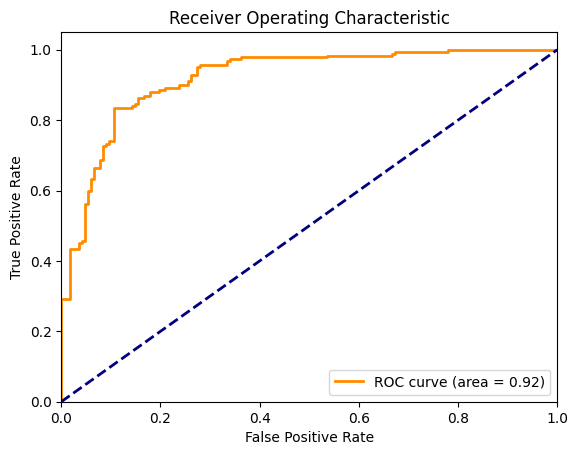

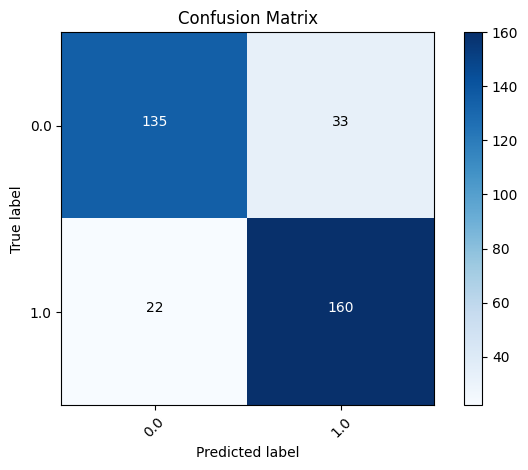

              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83       168
         1.0       0.83      0.88      0.85       182

    accuracy                           0.84       350
   macro avg       0.84      0.84      0.84       350
weighted avg       0.84      0.84      0.84       350

Dataset 2: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\Heart_disease_cleveland_new_augmented.csv
[TRAINING TIME] Classifier 1: 0.00 seconds
[INFERENCE TIME] Classifier 1 on Heart_disease_cleveland_new_augmented.csv: 0.00 seconds
Accuracy: 0.8080
F1-score: 0.8080
Log-loss: 0.4062
Precision: 0.8080
Recall: 0.8080
Balanced Accuracy: 0.8065
G-Mean: 0.8065
MCC: 0.6130
Cohen's Kappa: 0.6130
ROC AUC: 0.8958


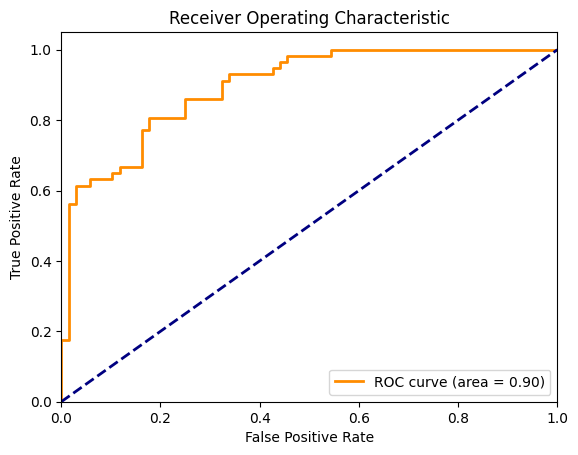

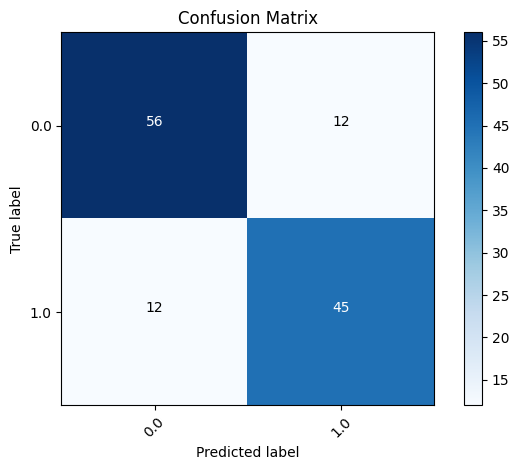

              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82        68
         1.0       0.79      0.79      0.79        57

    accuracy                           0.81       125
   macro avg       0.81      0.81      0.81       125
weighted avg       0.81      0.81      0.81       125

Dataset 3: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\framingham_balanced1_augmented.csv
[TRAINING TIME] Classifier 1: 0.02 seconds
[INFERENCE TIME] Classifier 1 on framingham_balanced1_augmented.csv: 0.00 seconds
Accuracy: 0.6880
F1-score: 0.6878
Log-loss: 0.5908
Precision: 0.6886
Recall: 0.6880
Balanced Accuracy: 0.6880
G-Mean: 0.6880
MCC: 0.3766
Cohen's Kappa: 0.3760
ROC AUC: 0.7498


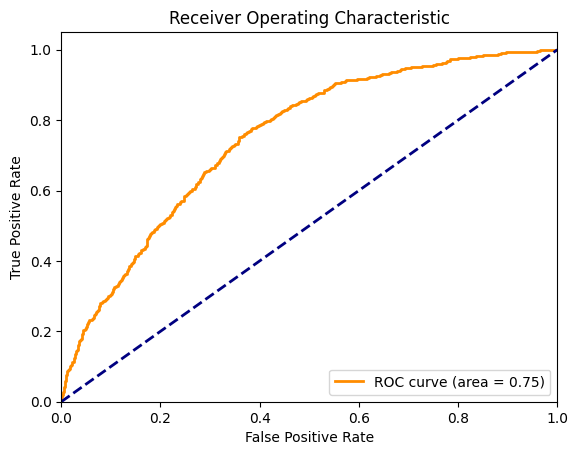

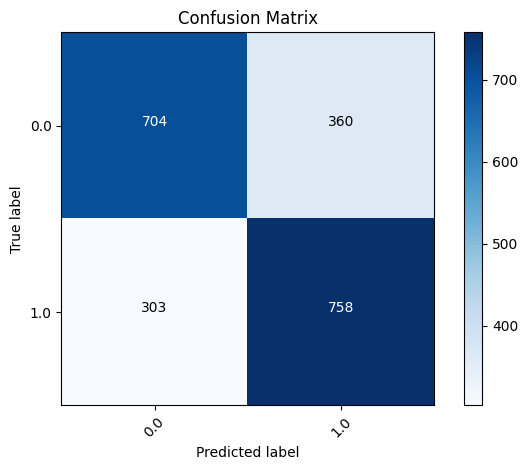

              precision    recall  f1-score   support

         0.0       0.70      0.66      0.68      1064
         1.0       0.68      0.71      0.70      1061

    accuracy                           0.69      2125
   macro avg       0.69      0.69      0.69      2125
weighted avg       0.69      0.69      0.69      2125

Dataset 4: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\heart_augmented.csv
[TRAINING TIME] Classifier 1: 0.02 seconds
[INFERENCE TIME] Classifier 1 on heart_augmented.csv: 0.00 seconds
Accuracy: 0.8800
F1-score: 0.8789
Log-loss: 0.3392
Precision: 0.8835
Recall: 0.8800
Balanced Accuracy: 0.8728
G-Mean: 0.8728
MCC: 0.7595
Cohen's Kappa: 0.7545
ROC AUC: 0.9205


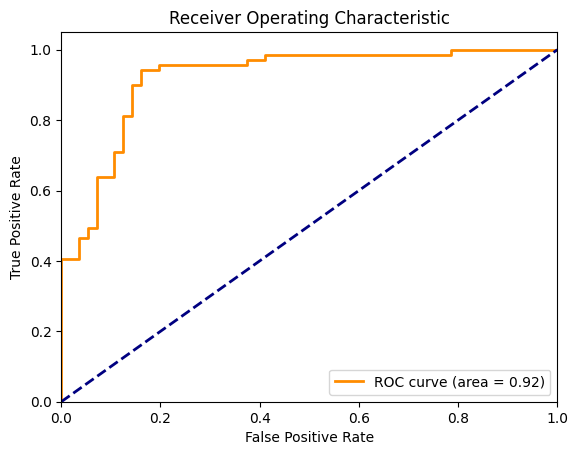

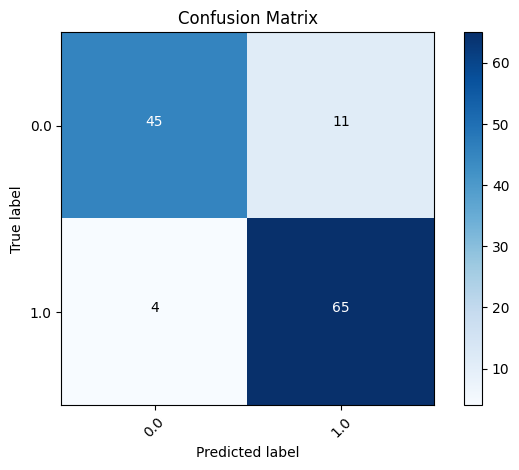

              precision    recall  f1-score   support

         0.0       0.92      0.80      0.86        56
         1.0       0.86      0.94      0.90        69

    accuracy                           0.88       125
   macro avg       0.89      0.87      0.88       125
weighted avg       0.88      0.88      0.88       125

Dataset 5: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\cardio_train_augmented.csv
[TRAINING TIME] Classifier 1: 0.18 seconds
[INFERENCE TIME] Classifier 1 on cardio_train_augmented.csv: 0.00 seconds
Accuracy: 0.7180
F1-score: 0.7175
Log-loss: 0.5765
Precision: 0.7195
Recall: 0.7180
Balanced Accuracy: 0.7180
G-Mean: 0.7180
MCC: 0.4374
Cohen's Kappa: 0.4359
ROC AUC: 0.7813


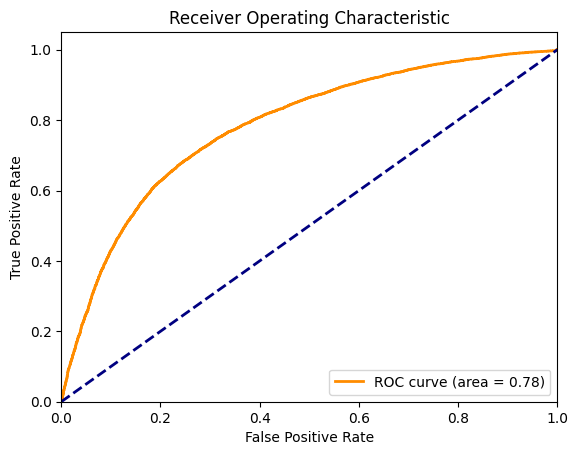

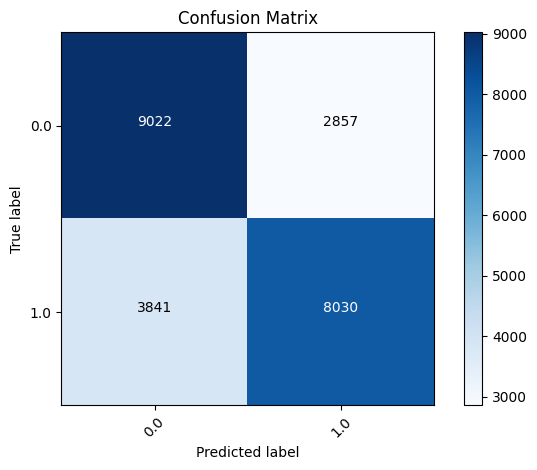

              precision    recall  f1-score   support

         0.0       0.70      0.76      0.73     11879
         1.0       0.74      0.68      0.71     11871

    accuracy                           0.72     23750
   macro avg       0.72      0.72      0.72     23750
weighted avg       0.72      0.72      0.72     23750



In [9]:
# BLOCK 9: Evaluate Logistic Regression (Classifier 1)
classifier_choice = 1
print(f"Classifier {classifier_choice}: Logistic Regression")
evaluate_model(classifier_choice)

Classifier 2: Random Forest
Classifier 2:
Dataset 1: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\heart1_augmented.csv
[TRAINING TIME] Classifier 2: 0.18 seconds
[INFERENCE TIME] Classifier 2 on heart1_augmented.csv: 0.01 seconds
Accuracy: 0.9886
F1-score: 0.9886
Log-loss: 0.0592
Precision: 0.9886
Recall: 0.9886
Balanced Accuracy: 0.9883
G-Mean: 0.9883
MCC: 0.9772
Cohen's Kappa: 0.9771
ROC AUC: 0.9996


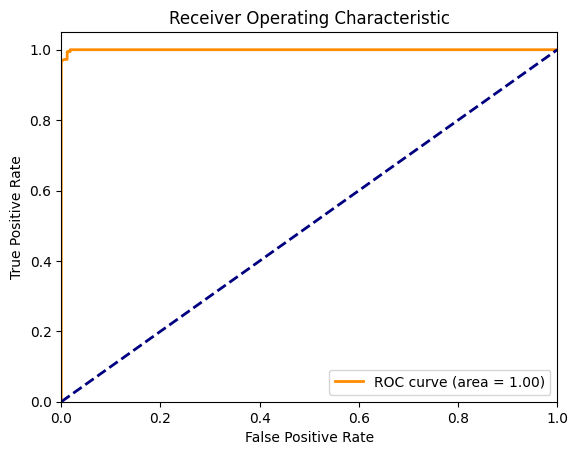

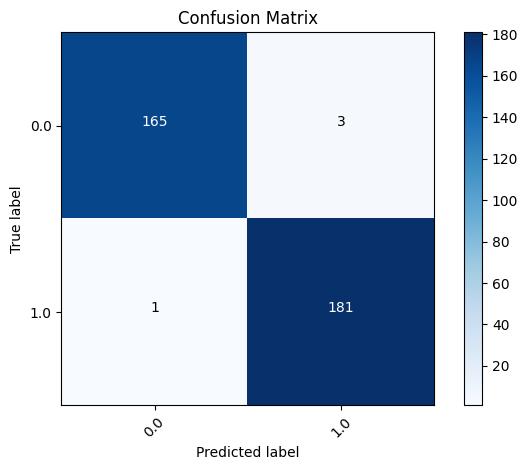

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       168
         1.0       0.98      0.99      0.99       182

    accuracy                           0.99       350
   macro avg       0.99      0.99      0.99       350
weighted avg       0.99      0.99      0.99       350

Dataset 2: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\Heart_disease_cleveland_new_augmented.csv
[TRAINING TIME] Classifier 2: 0.11 seconds
[INFERENCE TIME] Classifier 2 on Heart_disease_cleveland_new_augmented.csv: 0.01 seconds
Accuracy: 0.9280
F1-score: 0.9279
Log-loss: 0.2327
Precision: 0.9280
Recall: 0.9280
Balanced Accuracy: 0.9267
G-Mean: 0.9267
MCC: 0.8548
Cohen's Kappa: 0.8547
ROC AUC: 0.9769


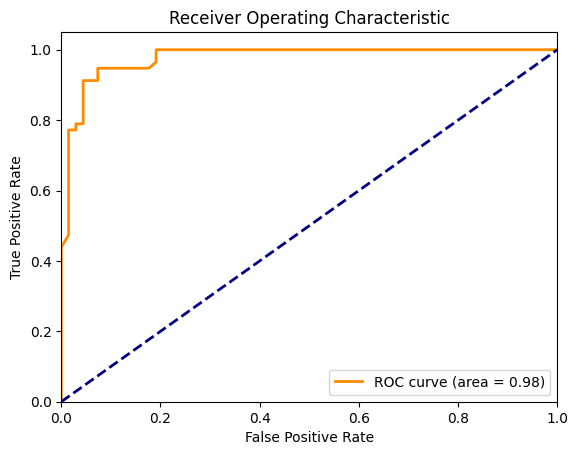

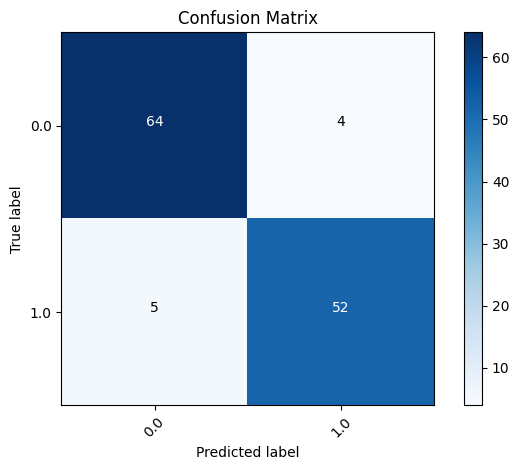

              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93        68
         1.0       0.93      0.91      0.92        57

    accuracy                           0.93       125
   macro avg       0.93      0.93      0.93       125
weighted avg       0.93      0.93      0.93       125

Dataset 3: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\framingham_balanced1_augmented.csv
[TRAINING TIME] Classifier 2: 0.80 seconds
[INFERENCE TIME] Classifier 2 on framingham_balanced1_augmented.csv: 0.06 seconds
Accuracy: 0.9021
F1-score: 0.9021
Log-loss: 0.3175
Precision: 0.9029
Recall: 0.9021
Balanced Accuracy: 0.9021
G-Mean: 0.9021
MCC: 0.8050
Cohen's Kappa: 0.8042
ROC AUC: 0.9693


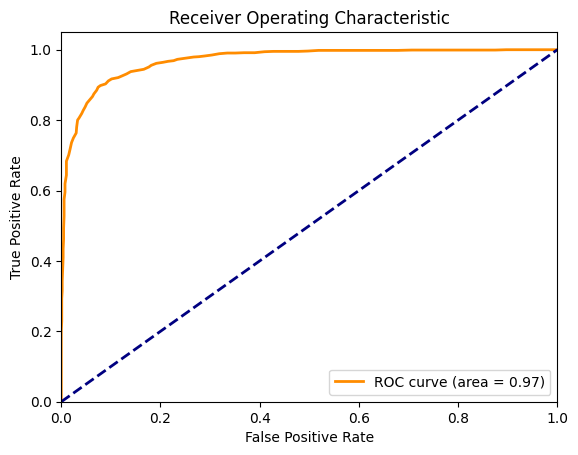

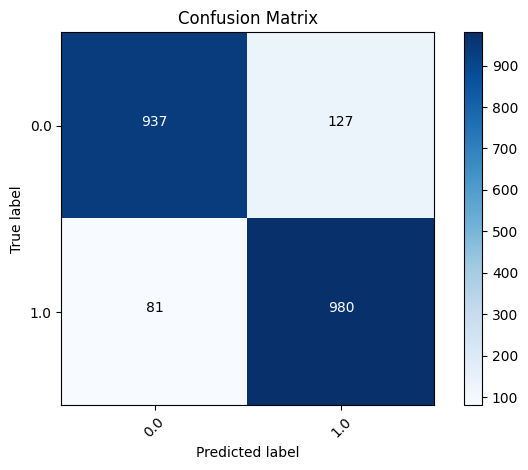

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      1064
         1.0       0.89      0.92      0.90      1061

    accuracy                           0.90      2125
   macro avg       0.90      0.90      0.90      2125
weighted avg       0.90      0.90      0.90      2125

Dataset 4: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\heart_augmented.csv
[TRAINING TIME] Classifier 2: 0.14 seconds
[INFERENCE TIME] Classifier 2 on heart_augmented.csv: 0.00 seconds
Accuracy: 0.8880
F1-score: 0.8878
Log-loss: 0.2312
Precision: 0.8880
Recall: 0.8880
Balanced Accuracy: 0.8851
G-Mean: 0.8851
MCC: 0.7732
Cohen's Kappa: 0.7728
ROC AUC: 0.9696


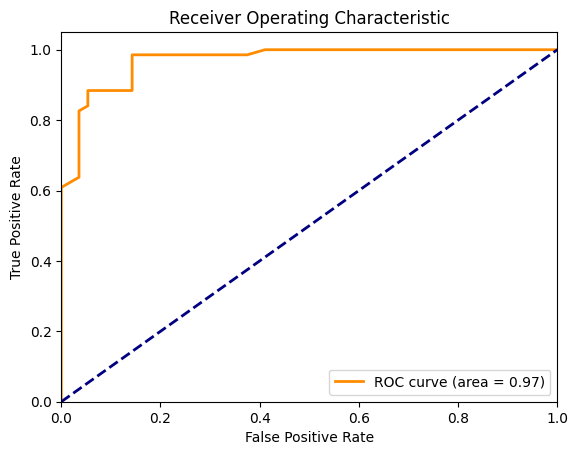

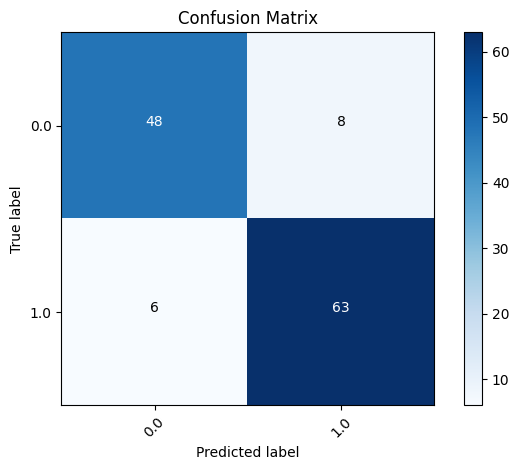

              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87        56
         1.0       0.89      0.91      0.90        69

    accuracy                           0.89       125
   macro avg       0.89      0.89      0.89       125
weighted avg       0.89      0.89      0.89       125

Dataset 5: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\cardio_train_augmented.csv
[TRAINING TIME] Classifier 2: 7.63 seconds
[INFERENCE TIME] Classifier 2 on cardio_train_augmented.csv: 1.07 seconds
Accuracy: 0.7419
F1-score: 0.7417
Log-loss: 0.5439
Precision: 0.7422
Recall: 0.7419
Balanced Accuracy: 0.7418
G-Mean: 0.7418
MCC: 0.4841
Cohen's Kappa: 0.4837
ROC AUC: 0.8100


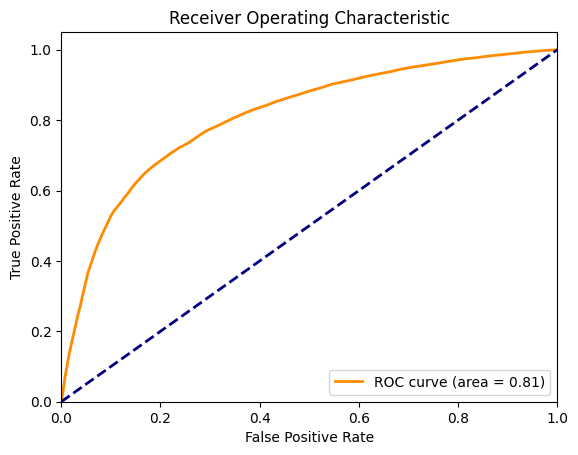

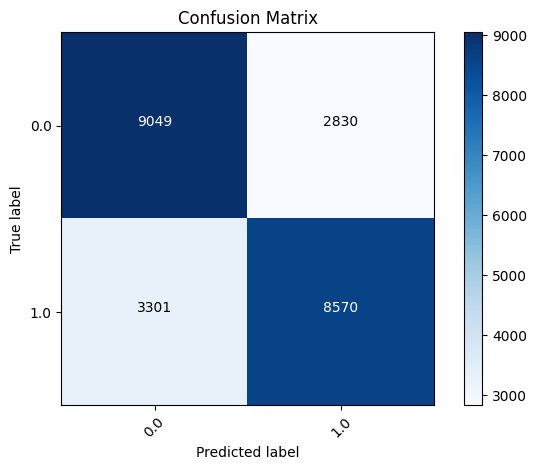

              precision    recall  f1-score   support

         0.0       0.73      0.76      0.75     11879
         1.0       0.75      0.72      0.74     11871

    accuracy                           0.74     23750
   macro avg       0.74      0.74      0.74     23750
weighted avg       0.74      0.74      0.74     23750



In [10]:
# BLOCK 10: Evaluate Random Forest (Classifier 2)
classifier_choice = 2
print(f"Classifier {classifier_choice}: Random Forest")
evaluate_model(classifier_choice)

Classifier 3: k-Nearest Neighbors (kNN)
Classifier 3:
Dataset 1: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\heart1_augmented.csv
[TRAINING TIME] Classifier 3: 0.00 seconds
[INFERENCE TIME] Classifier 3 on heart1_augmented.csv: 0.02 seconds
Accuracy: 0.9343
F1-score: 0.9343
Log-loss: 0.3238
Precision: 0.9347
Recall: 0.9343
Balanced Accuracy: 0.9348
G-Mean: 0.9348
MCC: 0.8689
Cohen's Kappa: 0.8685
ROC AUC: 0.9830


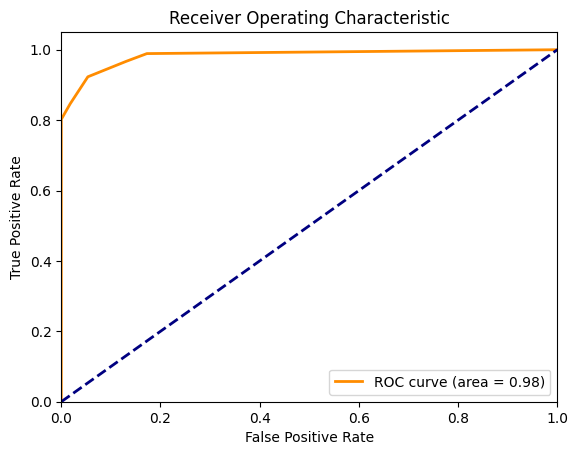

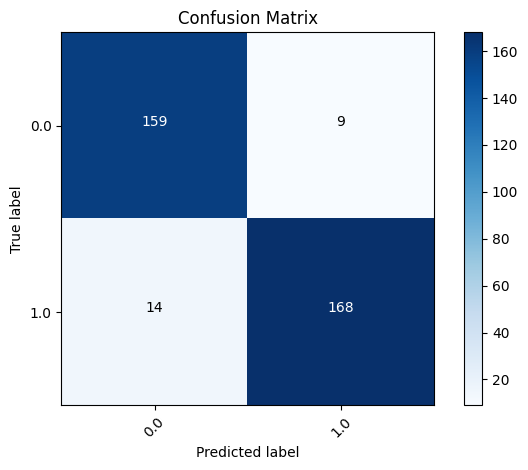

              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93       168
         1.0       0.95      0.92      0.94       182

    accuracy                           0.93       350
   macro avg       0.93      0.93      0.93       350
weighted avg       0.93      0.93      0.93       350

Dataset 2: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\Heart_disease_cleveland_new_augmented.csv
[TRAINING TIME] Classifier 3: 0.00 seconds
[INFERENCE TIME] Classifier 3 on Heart_disease_cleveland_new_augmented.csv: 0.00 seconds
Accuracy: 0.8480
F1-score: 0.8482
Log-loss: 1.1025
Precision: 0.8572
Recall: 0.8480
Balanced Accuracy: 0.8532
G-Mean: 0.8532
MCC: 0.7048
Cohen's Kappa: 0.6975
ROC AUC: 0.9303


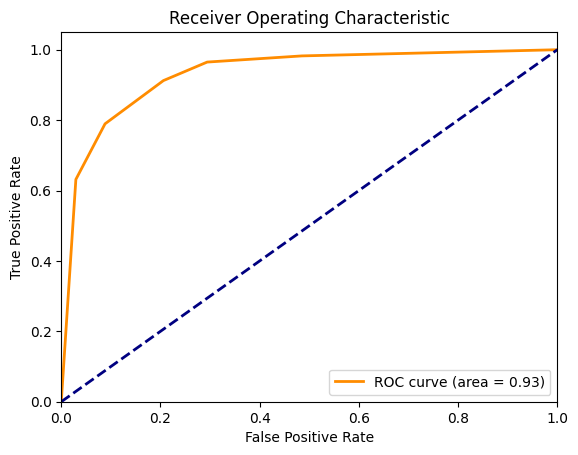

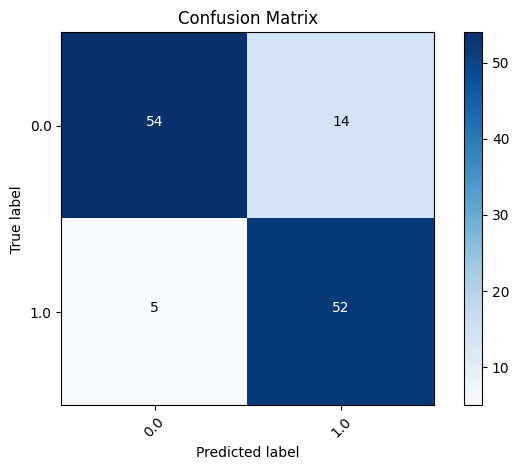

              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85        68
         1.0       0.79      0.91      0.85        57

    accuracy                           0.85       125
   macro avg       0.85      0.85      0.85       125
weighted avg       0.86      0.85      0.85       125

Dataset 3: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\framingham_balanced1_augmented.csv
[TRAINING TIME] Classifier 3: 0.01 seconds
[INFERENCE TIME] Classifier 3 on framingham_balanced1_augmented.csv: 0.20 seconds
Accuracy: 0.7793
F1-score: 0.7765
Log-loss: 1.5750
Precision: 0.7945
Recall: 0.7793
Balanced Accuracy: 0.7795
G-Mean: 0.7795
MCC: 0.5737
Cohen's Kappa: 0.5587
ROC AUC: 0.8643


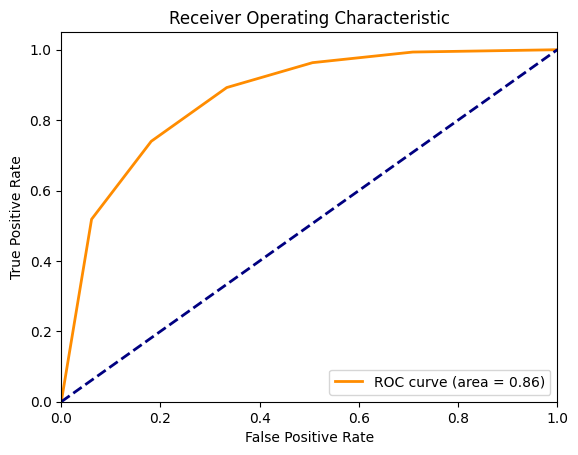

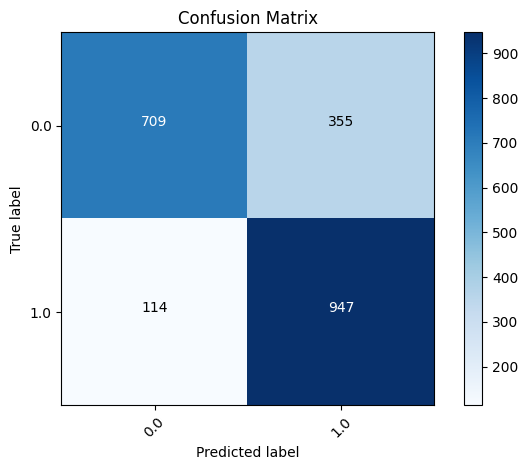

              precision    recall  f1-score   support

         0.0       0.86      0.67      0.75      1064
         1.0       0.73      0.89      0.80      1061

    accuracy                           0.78      2125
   macro avg       0.79      0.78      0.78      2125
weighted avg       0.79      0.78      0.78      2125

Dataset 4: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\heart_augmented.csv
[TRAINING TIME] Classifier 3: 0.00 seconds
[INFERENCE TIME] Classifier 3 on heart_augmented.csv: 0.00 seconds
Accuracy: 0.8480
F1-score: 0.8479
Log-loss: 1.6743
Precision: 0.8478
Recall: 0.8480
Balanced Accuracy: 0.8455
G-Mean: 0.8455
MCC: 0.6922
Cohen's Kappa: 0.6922
ROC AUC: 0.9032


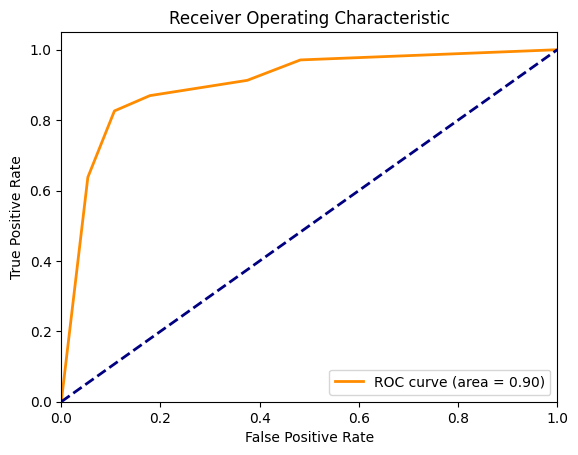

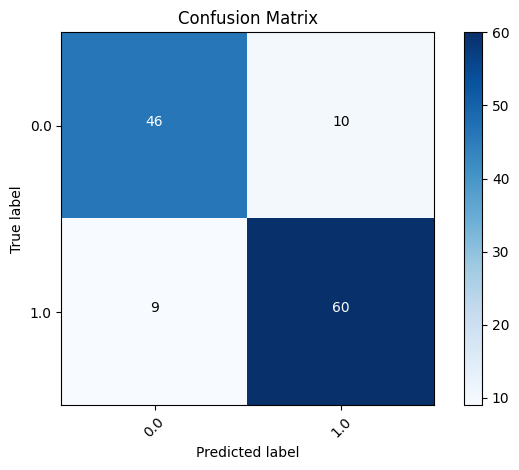

              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83        56
         1.0       0.86      0.87      0.86        69

    accuracy                           0.85       125
   macro avg       0.85      0.85      0.85       125
weighted avg       0.85      0.85      0.85       125

Dataset 5: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\cardio_train_augmented.csv
[TRAINING TIME] Classifier 3: 0.13 seconds
[INFERENCE TIME] Classifier 3 on cardio_train_augmented.csv: 7.18 seconds
Accuracy: 0.7077
F1-score: 0.7076
Log-loss: 2.1069
Precision: 0.7077
Recall: 0.7077
Balanced Accuracy: 0.7077
G-Mean: 0.7077
MCC: 0.4154
Cohen's Kappa: 0.4153
ROC AUC: 0.7631


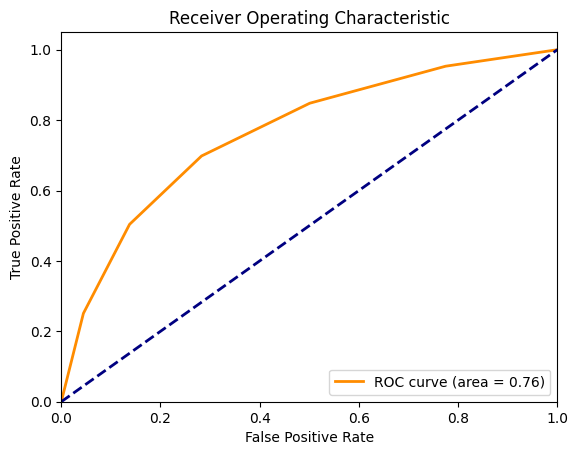

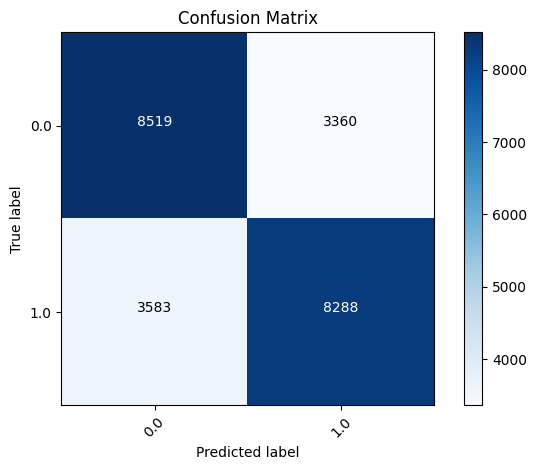

              precision    recall  f1-score   support

         0.0       0.70      0.72      0.71     11879
         1.0       0.71      0.70      0.70     11871

    accuracy                           0.71     23750
   macro avg       0.71      0.71      0.71     23750
weighted avg       0.71      0.71      0.71     23750



In [11]:
# BLOCK 11: Evaluate k-Nearest Neighbors (kNN) (Classifier 3)
classifier_choice = 3
print(f"Classifier {classifier_choice}: k-Nearest Neighbors (kNN)")
evaluate_model(classifier_choice)

Classifier 4: Support Vector Machines (SVM)
Classifier 4:
Dataset 1: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\heart1_augmented.csv
[TRAINING TIME] Classifier 4: 0.06 seconds
[INFERENCE TIME] Classifier 4 on heart1_augmented.csv: 0.03 seconds
Accuracy: 0.9486
F1-score: 0.9485
Log-loss: 0.1724
Precision: 0.9494
Recall: 0.9486
Balanced Accuracy: 0.9476
G-Mean: 0.9476
MCC: 0.8977
Cohen's Kappa: 0.8968
ROC AUC: 0.9746


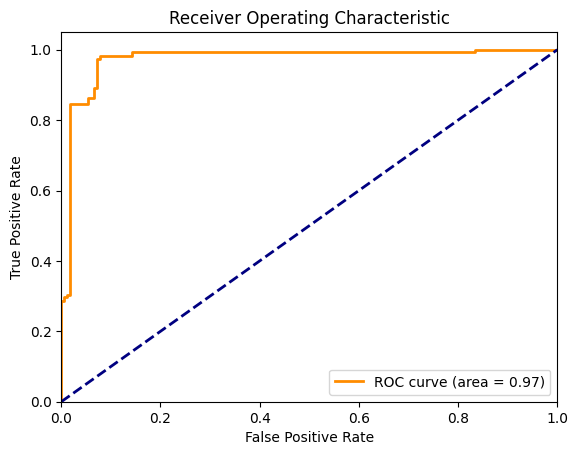

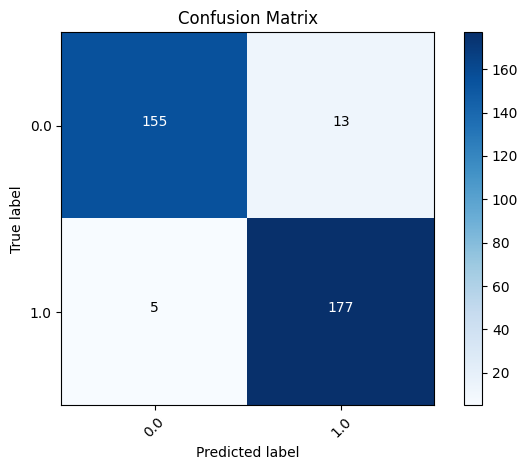

              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95       168
         1.0       0.93      0.97      0.95       182

    accuracy                           0.95       350
   macro avg       0.95      0.95      0.95       350
weighted avg       0.95      0.95      0.95       350

Dataset 2: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\Heart_disease_cleveland_new_augmented.csv
[TRAINING TIME] Classifier 4: 0.03 seconds
[INFERENCE TIME] Classifier 4 on Heart_disease_cleveland_new_augmented.csv: 0.00 seconds
Accuracy: 0.8640
F1-score: 0.8641
Log-loss: 0.3291
Precision: 0.8643
Recall: 0.8640
Balanced Accuracy: 0.8636
G-Mean: 0.8636
MCC: 0.7264
Cohen's Kappa: 0.7263
ROC AUC: 0.9386


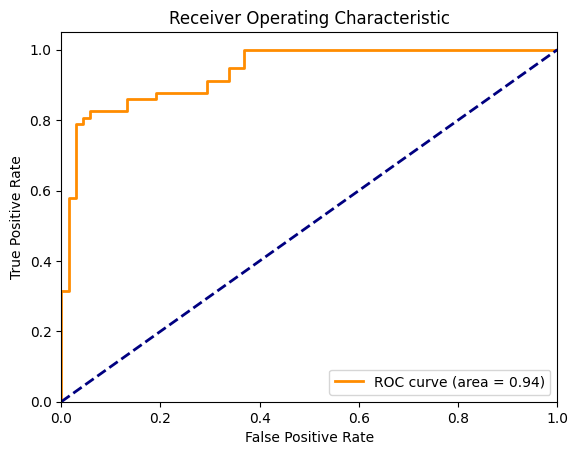

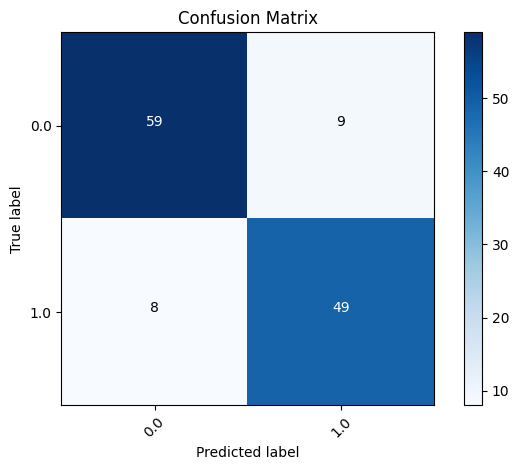

              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87        68
         1.0       0.84      0.86      0.85        57

    accuracy                           0.86       125
   macro avg       0.86      0.86      0.86       125
weighted avg       0.86      0.86      0.86       125

Dataset 3: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\framingham_balanced1_augmented.csv
[TRAINING TIME] Classifier 4: 5.82 seconds
[INFERENCE TIME] Classifier 4 on framingham_balanced1_augmented.csv: 1.11 seconds
Accuracy: 0.7454
F1-score: 0.7442
Log-loss: 0.5069
Precision: 0.7502
Recall: 0.7454
Balanced Accuracy: 0.7455
G-Mean: 0.7455
MCC: 0.4957
Cohen's Kappa: 0.4909
ROC AUC: 0.8288


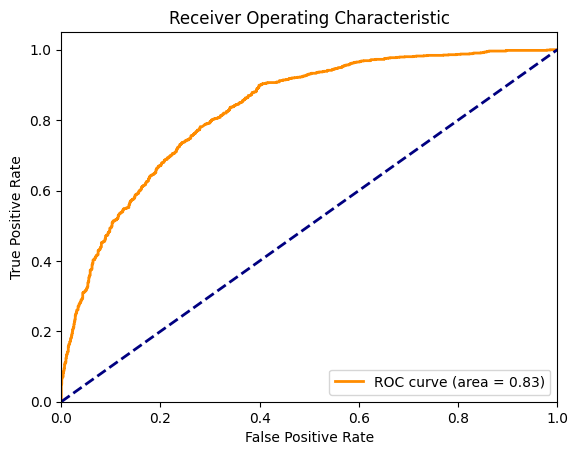

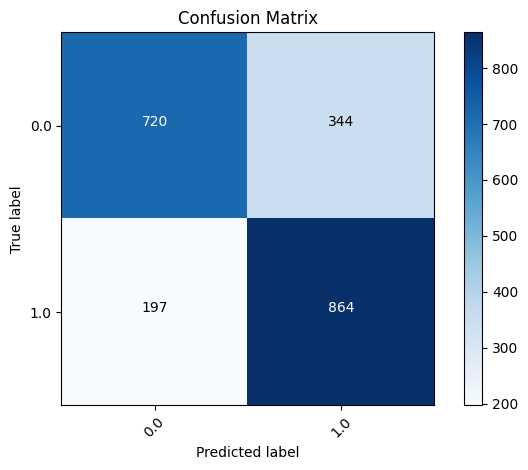

              precision    recall  f1-score   support

         0.0       0.79      0.68      0.73      1064
         1.0       0.72      0.81      0.76      1061

    accuracy                           0.75      2125
   macro avg       0.75      0.75      0.74      2125
weighted avg       0.75      0.75      0.74      2125

Dataset 4: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\heart_augmented.csv
[TRAINING TIME] Classifier 4: 0.02 seconds
[INFERENCE TIME] Classifier 4 on heart_augmented.csv: 0.00 seconds
Accuracy: 0.8960
F1-score: 0.8957
Log-loss: 0.3064
Precision: 0.8964
Recall: 0.8960
Balanced Accuracy: 0.8923
G-Mean: 0.8923
MCC: 0.7896
Cohen's Kappa: 0.7887
ROC AUC: 0.9407


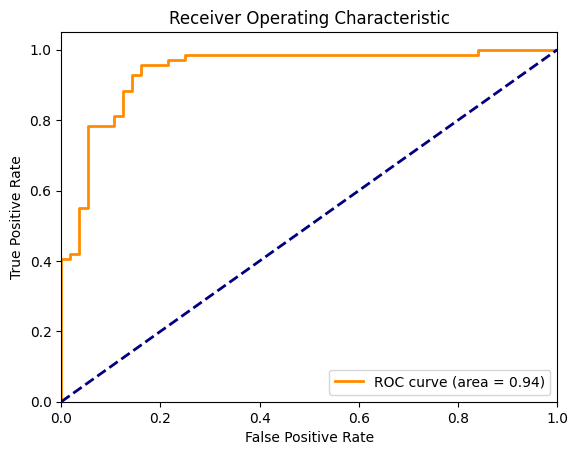

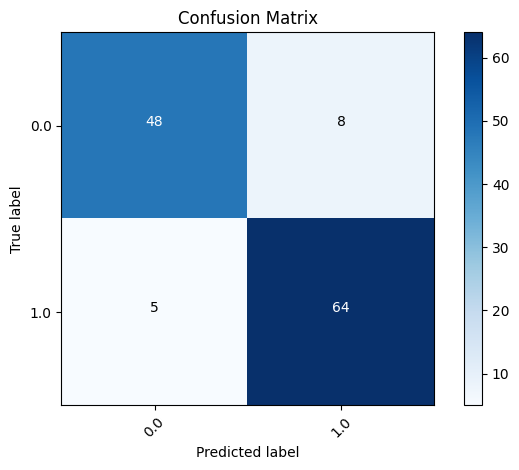

              precision    recall  f1-score   support

         0.0       0.91      0.86      0.88        56
         1.0       0.89      0.93      0.91        69

    accuracy                           0.90       125
   macro avg       0.90      0.89      0.89       125
weighted avg       0.90      0.90      0.90       125

Dataset 5: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\cardio_train_augmented.csv
[TRAINING TIME] Classifier 4: 1015.12 seconds
[INFERENCE TIME] Classifier 4 on cardio_train_augmented.csv: 136.78 seconds
Accuracy: 0.7257
F1-score: 0.7243
Log-loss: 0.5631
Precision: 0.7304
Recall: 0.7257
Balanced Accuracy: 0.7257
G-Mean: 0.7257
MCC: 0.4561
Cohen's Kappa: 0.4514
ROC AUC: 0.7892


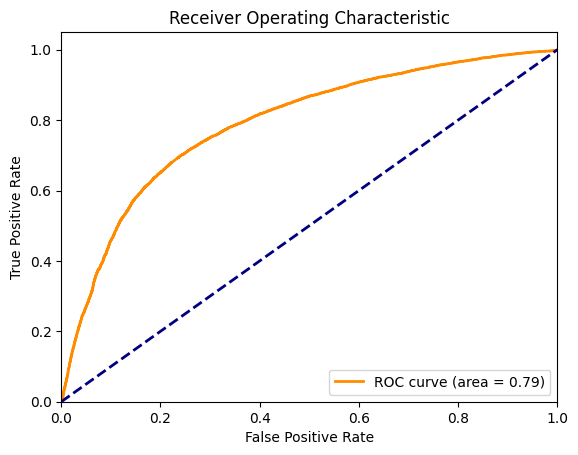

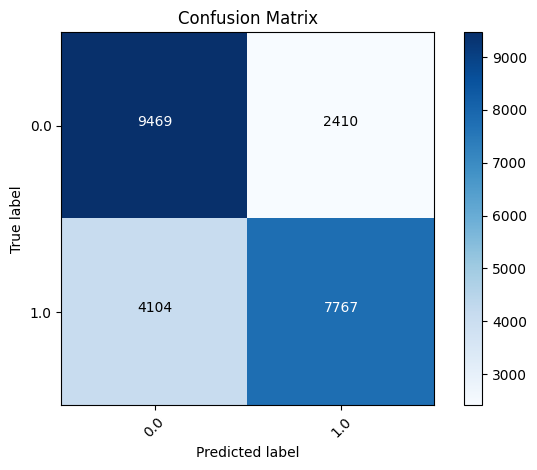

              precision    recall  f1-score   support

         0.0       0.70      0.80      0.74     11879
         1.0       0.76      0.65      0.70     11871

    accuracy                           0.73     23750
   macro avg       0.73      0.73      0.72     23750
weighted avg       0.73      0.73      0.72     23750



In [12]:
# BLOCK 12: Evaluate Support Vector Machines (SVM) (Classifier 4)
classifier_choice = 4
print(f"Classifier {classifier_choice}: Support Vector Machines (SVM)")
evaluate_model(classifier_choice)

Classifier 5: Deep Neural Network (DNN)
Classifier 5:
Dataset 1: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\heart1_augmented.csv
Epoch 1/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - AUC: 0.5441 - Precision: 0.5438 - Recall: 0.5438 - loss: 0.9275 - val_AUC: 0.8774 - val_Precision: 0.7985 - val_Recall: 0.7985 - val_loss: 0.6947 - learning_rate: 1.0000e-04
Epoch 2/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8563 - Precision: 0.7849 - Recall: 0.7849 - loss: 0.6314 - val_AUC: 0.9037 - val_Precision: 0.8132 - val_Recall: 0.8132 - val_loss: 0.6818 - learning_rate: 1.0000e-04
Epoch 3/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9029 - Precision: 0.8339 - Recall: 0.8339 - loss: 0.5809 - val_AUC: 0.9005 - val_Precision: 0.8059 - val_Recall: 0.8059 - val_loss: 0.6697 - learning_rate: 1.0000e-04
Epoch 4/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9113 - Precision: 0.8365 - Recall: 0.8365 - loss: 0.5706 - val_AUC: 0.9035 - val_Precision: 0.8095 - val_Recall: 0

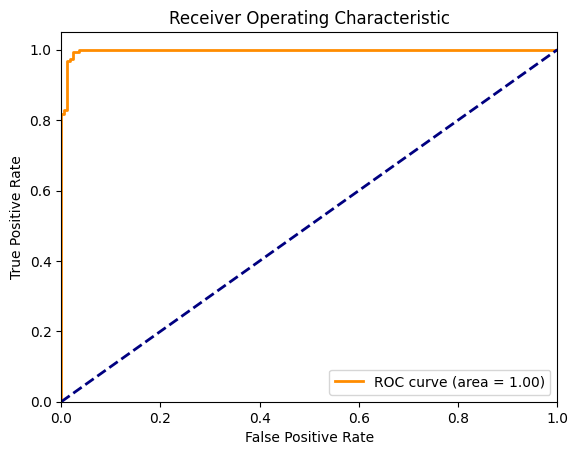

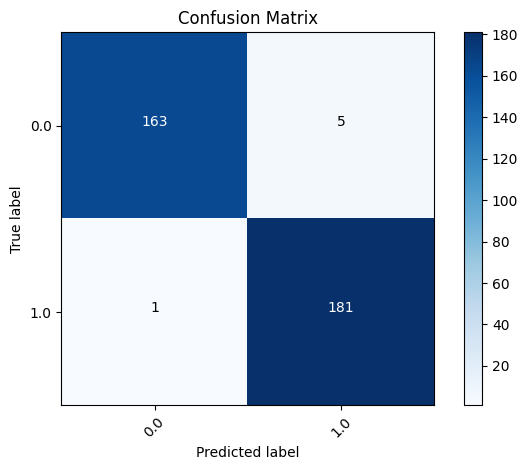

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       168
         1.0       0.97      0.99      0.98       182

    accuracy                           0.98       350
   macro avg       0.98      0.98      0.98       350
weighted avg       0.98      0.98      0.98       350

Dataset 2: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\Heart_disease_cleveland_new_augmented.csv
Epoch 1/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - AUC: 0.6141 - Precision: 0.6072 - Recall: 0.6072 - loss: 0.8557 - val_AUC: 0.7537 - val_Precision: 0.7059 - val_Recall: 0.7059 - val_loss: 0.7025 - learning_rate: 1.0000e-04
Epoch 2/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.6672 - Precision: 0.6029 - Recall: 0.6029 - loss: 0.7880 - val_AUC: 0.7951 - val_Precision: 0.7353 - val_Recall: 0.7353 - val_loss: 0.7000 - learning_rate: 1.0000e-04
Epoch 3/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.7863 - Precision: 0.7063 - Recall: 0.7063 - lo

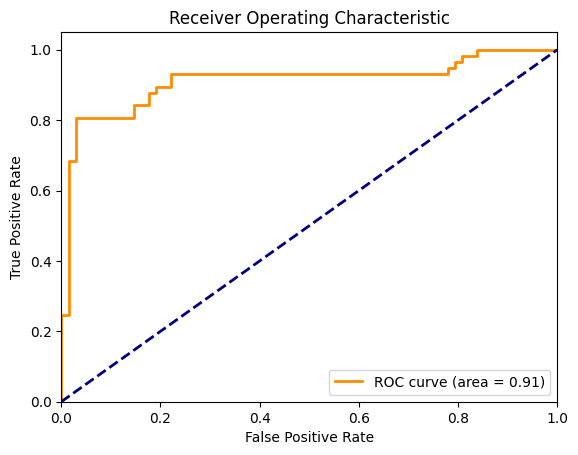

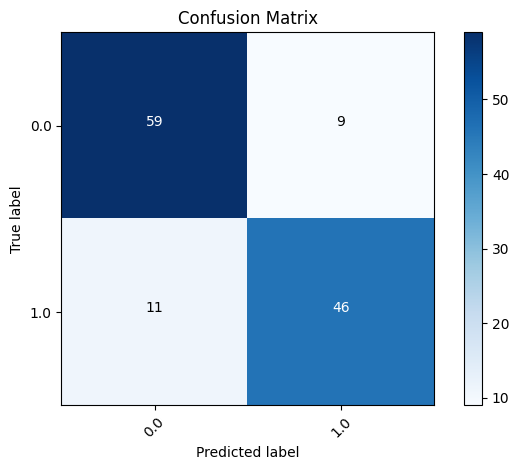

              precision    recall  f1-score   support

         0.0       0.84      0.87      0.86        68
         1.0       0.84      0.81      0.82        57

    accuracy                           0.84       125
   macro avg       0.84      0.84      0.84       125
weighted avg       0.84      0.84      0.84       125

Dataset 3: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\framingham_balanced1_augmented.csv
Epoch 1/250
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.6144 - Precision: 0.5849 - Recall: 0.5849 - loss: 0.8347 - val_AUC: 0.6929 - val_Precision: 0.6332 - val_Recall: 0.6332 - val_loss: 0.6976 - learning_rate: 1.0000e-04
Epoch 2/250
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6738 - Precision: 0.6328 - Recall: 0.6328 - loss: 0.7742 - val_AUC: 0.7321 - val_Precision: 0.6752 - val_Recall: 0.6752 - val_loss: 0.6686 - learning_rate: 1.0000e-04
Epoch 3/250
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7083 - Precision: 0.6481 - Recall: 0.6481 - loss:

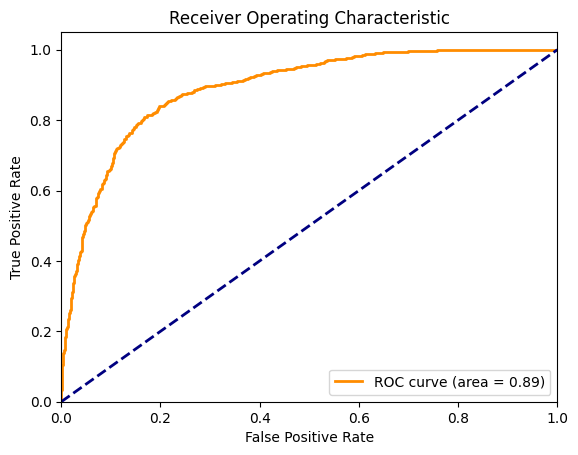

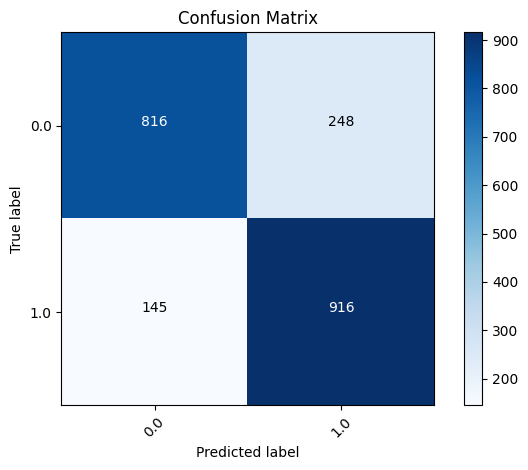

              precision    recall  f1-score   support

         0.0       0.85      0.77      0.81      1064
         1.0       0.79      0.86      0.82      1061

    accuracy                           0.82      2125
   macro avg       0.82      0.82      0.81      2125
weighted avg       0.82      0.82      0.81      2125

Dataset 4: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\heart_augmented.csv
Epoch 1/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - AUC: 0.4917 - Precision: 0.4829 - Recall: 0.4829 - loss: 0.9709 - val_AUC: 0.6508 - val_Precision: 0.6667 - val_Recall: 0.6667 - val_loss: 0.7086 - learning_rate: 1.0000e-04
Epoch 2/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.7390 - Precision: 0.6764 - Recall: 0.6764 - loss: 0.7423 - val_AUC: 0.8671 - val_Precision: 0.7905 - val_Recall: 0.7905 - val_loss: 0.6992 - learning_rate: 1.0000e-04
Epoch 3/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8116 - Precision: 0.7468 - Recall: 0.7468 - loss: 0.6736 - val_AUC: 

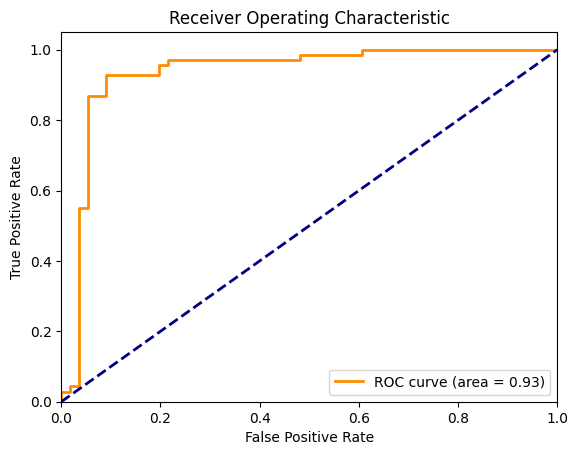

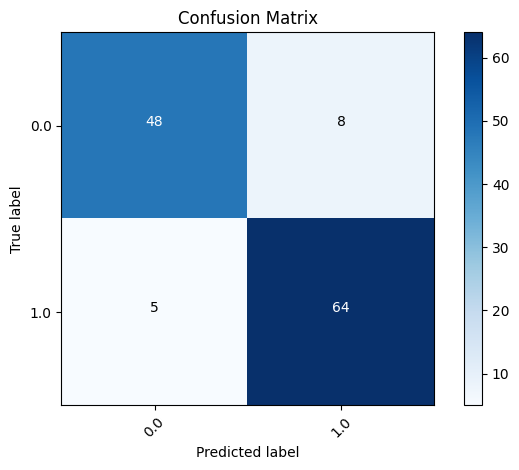

              precision    recall  f1-score   support

         0.0       0.91      0.86      0.88        56
         1.0       0.89      0.93      0.91        69

    accuracy                           0.90       125
   macro avg       0.90      0.89      0.89       125
weighted avg       0.90      0.90      0.90       125

Dataset 5: C:\Users\jakub\Visual Studio Code sem2\Magister\augmented\cardio_train_augmented.csv
Epoch 1/250
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.7122 - Precision: 0.6574 - Recall: 0.6574 - loss: 0.7283 - val_AUC: 0.7920 - val_Precision: 0.7270 - val_Recall: 0.7270 - val_loss: 0.6268 - learning_rate: 1.0000e-04
Epoch 2/250
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7517 - Precision: 0.6912 - Recall: 0.6912 - loss: 0.6266 - val_AUC: 0.7723 - val_Precision: 0.7090 - val_Recall: 0.7090 - val_loss: 0.5926 - learning_rate: 1.0000e-04
Epoch 3/250
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7691 - Precision: 0.7095 - Recall: 0.7095 - loss: 

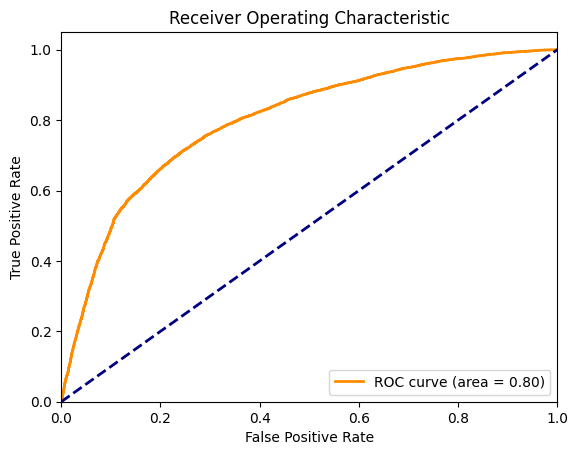

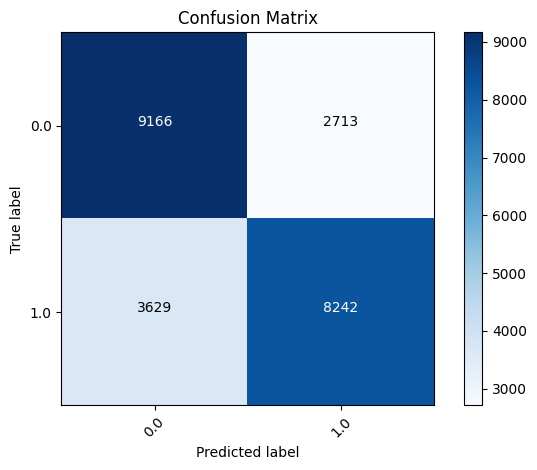

              precision    recall  f1-score   support

         0.0       0.72      0.77      0.74     11879
         1.0       0.75      0.69      0.72     11871

    accuracy                           0.73     23750
   macro avg       0.73      0.73      0.73     23750
weighted avg       0.73      0.73      0.73     23750



In [15]:
# BLOCK 13: Evaluate Deep Neural Network (DNN) (Classifier 5)
classifier_choice = 5
print(f"Classifier {classifier_choice}: Deep Neural Network (DNN)")
evaluate_model(classifier_choice)